# Lab 1 Task 1 - GPU Version
## 使用 PyTorch 和 GPU 進行 MNIST 手寫數字識別

這個版本使用 PyTorch 框架和 GPU 加速訓練，相比純 NumPy 版本有以下優勢：
- 🚀 **GPU 加速**：使用 CUDA 進行快速運算
- 🎯 **更高準確率**：更深的網路架構
- 📊 **更好的監控**：實時顯示 GPU 使用情況
- 🔧 **現代化**：使用 PyTorch 生態系統


In [1]:
# 導入必要的套件
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

print("✅ 套件導入完成")


✅ 套件導入完成


In [2]:
# GPU 環境檢查
print("🔍 GPU 環境檢查")
print("=" * 40)

# 檢查 CUDA 可用性
cuda_available = torch.cuda.is_available()
print(f"CUDA 可用: {'✅ 是' if cuda_available else '❌ 否'}")

if cuda_available:
    print(f"GPU 數量: {torch.cuda.device_count()}")
    print(f"當前 GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 記憶體: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    device = torch.device('cuda')
else:
    print("⚠️  將使用 CPU 訓練")
    device = torch.device('cpu')

print(f"\n🎯 使用設備: {device}")


🔍 GPU 環境檢查
CUDA 可用: ✅ 是
GPU 數量: 1
當前 GPU: Tesla V100-SXM2-32GB
GPU 記憶體: 31.7 GB

🎯 使用設備: cuda


In [3]:
# 定義 MLP 模型 (GPU 版本)
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10):
        super(MLP, self).__init__()
        
        # 構建層
        layers = []
        prev_size = input_size
        
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        
        # 輸出層
        layers.append(nn.Linear(prev_size, num_classes))
        
        # 組合所有層
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

# 創建模型並移到 GPU
model = MLP().to(device)
print(f"模型已創建並移到 {device}")
print(f"模型參數數量: {sum(p.numel() for p in model.parameters()):,}")

# 顯示模型結構
print("\n模型結構:")
print(model)


模型已創建並移到 cuda
模型參數數量: 567,434

模型結構:
MLP(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [4]:
# 數據預處理和載入
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 標準化到 [-1, 1]
])

# 載入 MNIST 數據集
train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# 分割訓練集和驗證集
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# 創建 DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"訓練集: {len(train_dataset)} 樣本")
print(f"驗證集: {len(val_dataset)} 樣本")
print(f"測試集: {len(test_dataset)} 樣本")
print(f"批次大小: {batch_size}")


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.32MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 152kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.41MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.70MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

訓練集: 54000 樣本
驗證集: 6000 樣本
測試集: 10000 樣本
批次大小: 64


In [5]:
# 訓練設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 20
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("🚀 開始 GPU 訓練...")
print(f"優化器: Adam")
print(f"學習率: 0.001")
print(f"訓練輪數: {epochs}")
print(f"損失函數: CrossEntropyLoss")
print(f"使用設備: {device}")


🚀 開始 GPU 訓練...
優化器: Adam
學習率: 0.001
訓練輪數: 20
損失函數: CrossEntropyLoss
使用設備: cuda


In [6]:
# 訓練和驗證函數
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc="訓練中")):
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)  # 展平為 784 維
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="驗證中"):
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

print("✅ 訓練函數已定義")


✅ 訓練函數已定義


In [7]:
# 執行訓練
print("🔥 開始訓練...")
print("=" * 50)

for epoch in range(epochs):
    # 訓練
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 驗證
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    # 更新學習率
    scheduler.step()
    
    # 記錄結果
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # 顯示進度
    print(f"Epoch {epoch+1:2d}/{epochs}: ")
    print(f"  訓練 - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  驗證 - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    print(f"  學習率: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 50)

print("✅ 訓練完成！")


🔥 開始訓練...


驗證中: 100%|██████████| 94/94 [00:01<00:00, 88.82it/s] 


Epoch  1/20: 
  訓練 - Loss: 0.3405, Acc: 89.24%
  驗證 - Loss: 0.2444, Acc: 91.93%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 84.19it/s] 


Epoch  2/20: 
  訓練 - Loss: 0.1515, Acc: 95.33%
  驗證 - Loss: 0.1214, Acc: 96.13%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 105.56it/s]


Epoch  3/20: 
  訓練 - Loss: 0.1151, Acc: 96.35%
  驗證 - Loss: 0.1176, Acc: 96.57%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 94.59it/s] 


Epoch  4/20: 
  訓練 - Loss: 0.0944, Acc: 97.04%
  驗證 - Loss: 0.1203, Acc: 96.28%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 87.72it/s] 


Epoch  5/20: 
  訓練 - Loss: 0.0792, Acc: 97.55%
  驗證 - Loss: 0.0998, Acc: 97.20%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 96.76it/s] 


Epoch  6/20: 
  訓練 - Loss: 0.0696, Acc: 97.78%
  驗證 - Loss: 0.1219, Acc: 96.30%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 90.32it/s] 


Epoch  7/20: 
  訓練 - Loss: 0.0617, Acc: 97.98%
  驗證 - Loss: 0.1354, Acc: 96.25%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 99.49it/s] 


Epoch  8/20: 
  訓練 - Loss: 0.0560, Acc: 98.21%
  驗證 - Loss: 0.1207, Acc: 96.82%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 88.12it/s] 


Epoch  9/20: 
  訓練 - Loss: 0.0490, Acc: 98.42%
  驗證 - Loss: 0.0991, Acc: 97.23%
  學習率: 0.001000
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 85.11it/s] 


Epoch 10/20: 
  訓練 - Loss: 0.0473, Acc: 98.47%
  驗證 - Loss: 0.1031, Acc: 97.42%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 81.27it/s] 


Epoch 11/20: 
  訓練 - Loss: 0.0158, Acc: 99.53%
  驗證 - Loss: 0.0726, Acc: 98.15%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 85.43it/s] 


Epoch 12/20: 
  訓練 - Loss: 0.0099, Acc: 99.74%
  驗證 - Loss: 0.0730, Acc: 98.30%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 96.81it/s] 


Epoch 13/20: 
  訓練 - Loss: 0.0078, Acc: 99.80%
  驗證 - Loss: 0.0770, Acc: 98.15%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 92.04it/s] 


Epoch 14/20: 
  訓練 - Loss: 0.0065, Acc: 99.84%
  驗證 - Loss: 0.0766, Acc: 98.23%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 84.70it/s] 


Epoch 15/20: 
  訓練 - Loss: 0.0053, Acc: 99.88%
  驗證 - Loss: 0.0809, Acc: 98.22%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 96.89it/s] 


Epoch 16/20: 
  訓練 - Loss: 0.0042, Acc: 99.91%
  驗證 - Loss: 0.0906, Acc: 98.13%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 94.14it/s] 


Epoch 17/20: 
  訓練 - Loss: 0.0035, Acc: 99.91%
  驗證 - Loss: 0.0869, Acc: 98.35%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:01<00:00, 88.98it/s] 


Epoch 18/20: 
  訓練 - Loss: 0.0028, Acc: 99.93%
  驗證 - Loss: 0.0953, Acc: 98.15%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 94.70it/s] 


Epoch 19/20: 
  訓練 - Loss: 0.0022, Acc: 99.95%
  驗證 - Loss: 0.0998, Acc: 98.10%
  學習率: 0.000100
--------------------------------------------------


驗證中: 100%|██████████| 94/94 [00:00<00:00, 99.01it/s] 

Epoch 20/20: 
  訓練 - Loss: 0.0017, Acc: 99.97%
  驗證 - Loss: 0.0997, Acc: 98.23%
  學習率: 0.000010
--------------------------------------------------
✅ 訓練完成！


In [8]:
# 測試模型
print("🧪 測試模型...")
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"測試結果:")
print(f"  測試 Loss: {test_loss:.4f}")
print(f"  測試 Accuracy: {test_acc:.2f}%")


🧪 測試模型...


驗證中: 100%|██████████| 157/157 [00:01<00:00, 97.74it/s] 

測試結果:
  測試 Loss: 0.0842
  測試 Accuracy: 98.33%


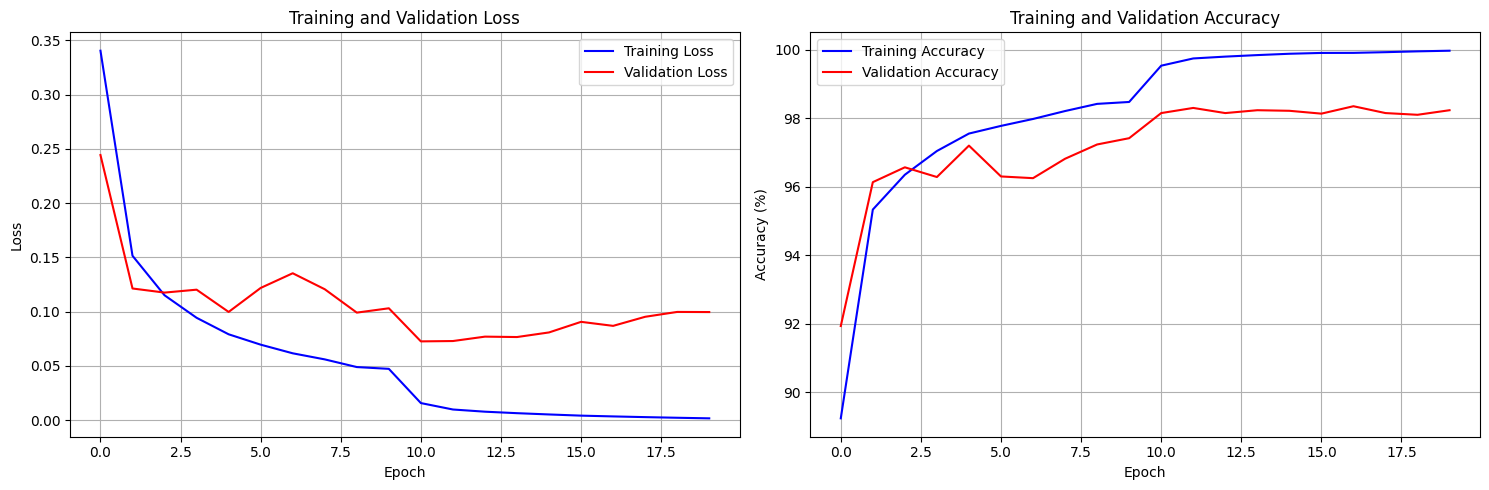


🎯 最終結果:
  最佳驗證準確率: 98.35%
  測試準確率: 98.33%
  使用設備: cuda


In [9]:
# 繪製訓練曲線
plt.figure(figsize=(15, 5))

# Loss 曲線
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy 曲線
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n🎯 最終結果:")
print(f"  最佳驗證準確率: {max(val_accuracies):.2f}%")
print(f"  測試準確率: {test_acc:.2f}%")
print(f"  使用設備: {device}")


In [10]:
# GPU 使用情況監控
if torch.cuda.is_available():
    print("🖥️ GPU 使用情況:")
    print(f"  已分配記憶體: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"  快取記憶體: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")
    print(f"  最大已分配: {torch.cuda.max_memory_allocated() / 1024**3:.2f} GB")
    
    # 清理 GPU 記憶體
    torch.cuda.empty_cache()
    print("✅ GPU 記憶體已清理")
else:
    print("ℹ️  使用 CPU 訓練，無 GPU 記憶體資訊")


🖥️ GPU 使用情況:
  已分配記憶體: 0.02 GB
  快取記憶體: 0.04 GB
  最大已分配: 0.03 GB
✅ GPU 記憶體已清理
